In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as sts

In [4]:
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables
Base.classes.keys()

['measurement', 'station']

In [8]:
# We can view all of the classes that automap found


In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x20776178c18>,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716}

In [12]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x207761bd2e8>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

# Exploratory Climate Analysis

In [13]:
# Total number of dates
session.query(func.count(Measurement.date)).all()

[(19550)]

In [14]:
engine.execute('SELECT * FROM measurement where measurement.date = "2010-01-01"').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2725, 'USC00513117', '2010-01-01', 0.28, 67.0),
 (9008, 'USC00518838', '2010-01-01', 0.21, 72.0),
 (9519, 'USC00519523', '2010-01-01', 0.15, 75.0),
 (12188, 'USC00519281', '2010-01-01', 0.15, 70.0),
 (14960, 'USC00511918', '2010-01-01', 0.05, 66.0),
 (16939, 'USC00516128', '2010-01-01', 0.14, 73.0)]

In [15]:
# Find the latest date that precipitation data was recorded
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date

('2017-08-23')

In [16]:
#Calculate the date 1 year ago from the last data point in the database
start_date = dt.date(2017,8,23) - dt.timedelta(days=365)
print(start_date)

2016-08-23


In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#Perform a query to retrieve the data and precipitation scores
prcp_measurements = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > start_date).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_measurements_df = pd.DataFrame(prcp_measurements)
prcp_measurements_df.set_index('date',inplace = True)

# Sort the dataframe by date
prcp_measurements_df.sort_values('date',ascending=True,inplace=True)

# Drop any NaN values as they are not useful to the analysis
prcp_measurements_df.dropna(inplace=True)
prcp_measurements_df

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15
...,...
2017-08-22,0.50
2017-08-23,0.08
2017-08-23,0.00


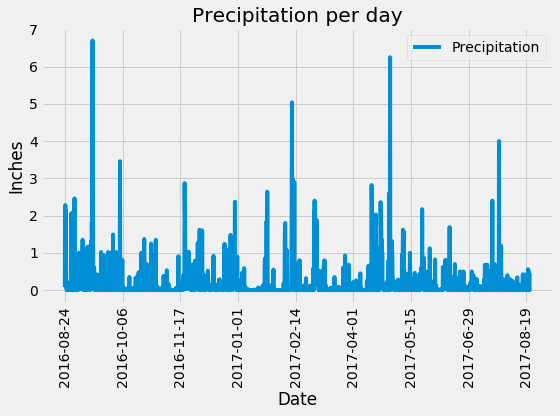

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_measurements_df.plot(rot='vertical',figsize = (8,6))
ax.legend(["Precipitation"]);

# Set labels and Title.
plt.title("Precipitation per day")
plt.xlabel("Date")
plt.ylabel("Inches")

# Save and show the graph.
plt.tight_layout()
plt.savefig("plots/dailyprecipitation.png")
plt.show()

In [30]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_measurements_df.describe()
prcp_mean = round(prcp_measurements_df['prcp'].astype('float').mean(), 2)
prcp_median = round(prcp_measurements_df['prcp'].astype('float').median(), 2)
prcp_mode = sts.mode(prcp_measurements_df['prcp'])
prcp_max = round(prcp_measurements_df['prcp'].astype('float').max(), 2)
prcp_min = round(prcp_measurements_df['prcp'].astype('float').min(), 2)
prcp_std = round(prcp_measurements_df['prcp'].std(),2)
prcp_var = round(prcp_measurements_df['prcp'].var(),2)

print(f"******************* SUMMARY PRECIPITATION STATISTICS *************************")
print("")
print(f"The Maximum recorded precipitation over the 1 year period: {prcp_max} inches")
print(f"The Minimum recorded precipitation over the 1 year period: {prcp_min} inches")
print(f"The Mean precipitation over the 1 year period: {prcp_mean} inches.")
print(f"The Median precipitation over the 1 year period: {prcp_median} inches")
print(f"The Mode precipitation over the 1 year period: {prcp_mode.mode[0]} inches")
print(f"The Standard Deviation of precipitation over the 1 year period is: {prcp_std} ")
print(f"The Variance of precipitation over the 1 year period is: {prcp_var} ")
print("")
print(f"******************************************************************************")
prcp_measurements_df.describe()

******************* SUMMARY PRECIPITATION STATISTICS *************************

The Maximum recorded precipitation over the 1 year period: 6.7 inches
The Minimum recorded precipitation over the 1 year period: 0.0 inches
The Mean precipitation over the 1 year period: 0.18 inches.
The Median precipitation over the 1 year period: 0.02 inches
The Mode precipitation over the 1 year period: 0.0 inches
The Standard Deviation of precipitation over the 1 year period is: 0.46 
The Variance of precipitation over the 1 year period is: 0.21 

******************************************************************************


,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [20]:
# Design a query to show how many stations are available in this dataset?
prcp_stations_count = session.query(Station).count()
print("--------------------------------------------------------------------")
print(f"There are a total of {prcp_stations_count} stations in the dataset.")
print("--------------------------------------------------------------------")

--------------------------------------------------------------------
There are a total of 9 stations in the dataset.
--------------------------------------------------------------------


In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station,
       func.count(Measurement.station)
      ]
most_active_stations = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

# List of the most active stations in descending order.
print("-------------------------------------------------------------------")
print("List of the most active stations (with counts) in descending order.")
print("-------------------------------------------------------------------")
for s in most_active_stations:
    print(s[0],s[1])

-------------------------------------------------------------------
List of the most active stations (with counts) in descending order.
-------------------------------------------------------------------
USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [22]:
counter = 0
for s in most_active_stations:
     if counter == 0:
         most_active_station = s[0]
         most_measurements = s[1]
         counter = counter + 1
     else:
        break
print("----------------------------------------------------------------------------------------")
print(f"The most active station is {most_active_station} with {most_measurements} measurements.")
print("----------------------------------------------------------------------------------------")

----------------------------------------------------------------------------------------
The most active station is USC00519281 with 2772 measurements.
----------------------------------------------------------------------------------------


In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)
      ]

temp_stats = session.query(*sel).filter(Measurement.station == 'USC00519281').all()
#print(temp_stats[1])
for s in temp_stats:
    print("-------------------------------------------------------------------")
    print(f"For Station {s[0]} :")
    print(f"The lowest temperature recorded was: {s[1]} degrees.")
    print(f"The highest temperature recorded was: {s[2]} degrees.")
    print(f"The average temperature was: {round(s[3],2)} degrees.")
    print("-------------------------------------------------------------------")

-------------------------------------------------------------------
For Station USC00519281 :
The lowest temperature recorded was: 54.0 degrees.
The highest temperature recorded was: 85.0 degrees.
The average temperature was: 71.66 degrees.
-------------------------------------------------------------------


In [24]:
# Choose the station with the highest number of temperature observations.
sel = [Measurement.station,
       func.count(Measurement.tobs)
      ]
most_active_temp_stations = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()

# List of the most active stations in descending order.
print("-------------------------------------------------------------------")
print("List of the most active stations (with counts) in descending order.")
print("-------------------------------------------------------------------")
for s in most_active_temp_stations:
    print(s[0],s[1])

-------------------------------------------------------------------
List of the most active stations (with counts) in descending order.
-------------------------------------------------------------------
USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [25]:
counter = 0
for s in most_active_temp_stations:
     if counter == 0:
         most_active_temp_station = s[0]
         most_measurements = s[1]
         counter = counter + 1
     else:
        break
print("---------------------------------------------------------------------------------------------")
print(f"The most active station is {most_active_temp_station} with {most_measurements} measurements.")
print("---------------------------------------------------------------------------------------------")

---------------------------------------------------------------------------------------------
The most active station is USC00519281 with 2772 measurements.
---------------------------------------------------------------------------------------------


In [26]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram.
# Find the latest date that temp data was recorded for this station USC00519281
station_temp_date_recent = session.query(Measurement.date).\
    filter(Measurement.station=="USC00519281").\
    order_by(Measurement.date.desc()).first()

#Calculate the date 1 year ago from the most recent temp recorded date for station USC00519281
station_temp_date_start = dt.date(2017,8,18) - dt.timedelta(days=365)

print("---------------------------------------------------------------------------------------------")
print(f"The most recent temperature measurement recorded at station {most_active_temp_station} was on: {station_temp_date_recent[0]}")
print(f"The date range for the last 12 month period for station {most_active_temp_station} begins on: {station_temp_date_start}")
print("---------------------------------------------------------------------------------------------")

---------------------------------------------------------------------------------------------
The most recent temperature measurement recorded at station USC00519281 was on: 2017-08-18
The date range for the last 12 month period for station USC00519281 begins on: 2016-08-18
---------------------------------------------------------------------------------------------


In [27]:
temp_hist = session.query(Measurement.tobs).filter(Measurement.station=="USC00519281").\
            filter(Measurement.date >= station_temp_date_start).\
            filter(Measurement.date <= station_temp_date_recent[0]).all()
temp_hist_df = pd.DataFrame(temp_hist)
temp_hist_df

,tobs
0,80.0
1,79.0
2,81.0
3,79.0
4,78.0
...,...
352,77.0
353,77.0
354,76.0
355,76.0


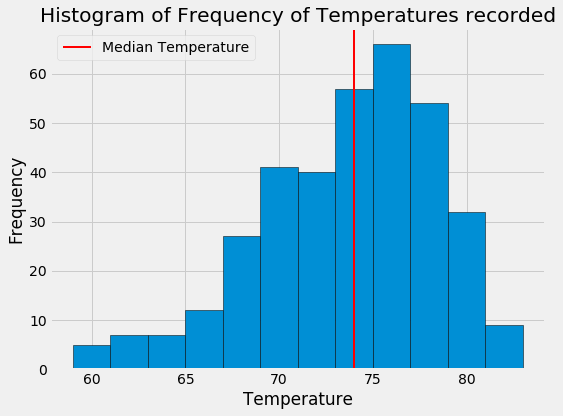

The median temperature is: 74.0


In [29]:
plt.figure(figsize=(8,6))

# Plot the histogram for the most recent year for station USC00519281 for 12 bins.
# Add edgecolor for better clarity of the individual bars.
plt.hist(temp_hist_df.tobs,bins=12,edgecolor='black')

# Calculate median temperature and show it as a line on the histogram
median_temp = temp_hist_df.tobs.median()
plt.axvline(median_temp,color = 'red', label = "Median Temperature", linewidth = 2)
plt.legend()

# Display titles, axis labels.
plt.title("Histogram of Frequency of Temperatures recorded")
plt.xlabel("Temperature")
plt.ylabel("Frequency")

# Save and show the graph.
plt.tight_layout()
plt.savefig("plots/histogramoftemps.png")
plt.show()

# Print the value of the median temp.
print(f"The median temperature is: {median_temp}")

## Bonus Challenge Assignment

In [28]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [31]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [32]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [33]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [34]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [35]:
# Plot the daily normals as an area plot with `stacked=False`
